#NJIT Undergraduate Research and Innovation (URI) Provost  Summer Research Fellowship: "Analyzing Interior Density in Army Ant Bivouacs."
Nidhi Sakpal, NJIT


##Documentation


This python pipeline measures radial intensity profiles (e.g., an ant bivouac) across a 3D image stack (multi-page TIFF). For each slice it:



*   Finds the largest connected component via thresholding.
*   Computes a Euclidean distance transform inside that object.
*   Partitions the object into concentric “donut” bands of fixed pixel thickness (SHRINK_STEP) from the outer edge inward.


For each band, records:


*   its outward distance (or midpoint) from the edge,
*   the band’s area (pixels),
*   the band’s median raw intensity (unblurred image). Can be changed to calculate the mean, SD.
*   Writes one CSV row per band per slice.

And then the program downloads the resulted csv file to your device.

The second cell turns the CSV into a heatmap (slice vs. distance) using a log-scaled color map.

**Tips + Recommendation:**
**Keep the scanned tiff files in a folder on drive, as Google Drive is mounted onto colab. After the program ends, upload the png images to the same folder in drive. Remember to change the name of the resulted csv to one that reflects your scan. Make sure to copy the path directly from drive to avoid confusion.**



In [1]:

!pip install scikit-image opencv-python pandas matplotlib tifffile
import numpy as np
import cv2
from skimage import measure
import pandas as pd
from tifffile import imread
from google.colab import files

In [6]:


!pip -q install tifffile tqdm

import os, glob, csv
import numpy as np
import pandas as pd
import cv2
from tifffile import TiffFile
from tqdm import tqdm
try:
    from google.colab import files as colab_files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

FILE_PATH            = "/content/drive/MyDrive/ants/20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.tif"  # <- set your path
OUTPUT_CSV           = "20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.csv" #change csv name
SHRINK_STEP          = 2       # band thickness in pixels
MIN_INNER_AREA       = 5       # stop when inner core < this many pixels
MIN_SELECTION_PIXELS = 10      # skip slice if largest CC area < this
GAUSS_KERNEL         = (5, 5)  # used only for mask; intensities use UNBLURRED image
INVERT_THRESH        = False   # light-on-dark (white ants) => False;
LABEL_DISTANCE_AS    = "edge"  # "edge" (outer edge of band)


# If filename varies (e.g., duplicate suffix), auto-pick latest matching file
if not os.path.exists(FILE_PATH):
    base = os.path.basename(FILE_PATH).split(".tif")[0]
    cands = sorted(glob.glob(f"/content/{base}*.tif"), key=lambda p: os.path.getmtime(p), reverse=True)
    if cands:
        FILE_PATH = cands[0]

def to_uint8_consistent(img):
    #Convert to grayscale uint8 with a consistent mapping.
    if img.ndim == 3 and img.shape[-1] in (3,4):
        img = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
    if img.dtype == np.uint16:
        return (img / 257.0).astype(np.uint8)
    if img.dtype != np.uint8:
        return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

def largest_component_mask(binary255):
    #Return 0/255 mask of largest connected component.
    fg = (binary255 > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(fg, connectivity=8)
    if num_labels <= 1:
        return np.zeros_like(binary255, dtype=np.uint8)
    areas = stats[1:, cv2.CC_STAT_AREA]
    max_idx = 1 + int(np.argmax(areas))
    return (labels == max_idx).astype(np.uint8) * 255

def process_slice_bandmedian(orig_u8, shrink_step=2, min_inner_area=5):
    #Compute donut bands for one slice: returns list of dicts with Distance, BandArea, BandMedian.

    if GAUSS_KERNEL:
        blurred = cv2.GaussianBlur(orig_u8, GAUSS_KERNEL, 0)
    else:
        blurred = orig_u8

    thresh_type = cv2.THRESH_OTSU | (cv2.THRESH_BINARY_INV if INVERT_THRESH else cv2.THRESH_BINARY)
    _, binary = cv2.threshold(blurred, 0, 255, thresh_type)

    mask255 = largest_component_mask(binary)
    sel_area = int(cv2.countNonZero(mask255))
    if sel_area < MIN_SELECTION_PIXELS:
        return []  # skips tiny or no-selection slices


    dist = cv2.distanceTransform((mask255 > 0).astype(np.uint8), distanceType=cv2.DIST_L2, maskSize=3)


    eps = 1e-6
    band_idx = ((dist + eps) // shrink_step).astype(np.int32)
    in_mask = (mask255 > 0)

    k_vals = band_idx[in_mask]
    if k_vals.size == 0:
        return []

    max_k = int(k_vals.max())
    areas = np.bincount(k_vals.ravel(), minlength=max_k + 1)  # TRUE pixel counts per band

    if LABEL_DISTANCE_AS == "mid":
        distances = (np.arange(max_k + 1) + 0.5) * shrink_step
    else:  # "edge": outer edge of each band
        distances = (np.arange(max_k + 1) + 1) * shrink_step

    # Inner-core stopping rule (like erosion): stop when remaining < min_inner_area
    total_area = int(in_mask.sum())
    removed_cumu = np.cumsum(areas)
    remaining_after_k = total_area - removed_cumu
    keep_band = (remaining_after_k >= min_inner_area)

    rows = []
    for k in range(max_k + 1):
        if areas[k] == 0:
            continue
        if not keep_band[k]:
            break
        band_mask = (band_idx == k) & in_mask
        vals = orig_u8[band_mask]
        if vals.size == 0:
            continue
        rows.append({
            "Distance": float(distances[k]),
            "BandArea": int(areas[k]),
            "BandMedian": float(np.median(vals)),
        })
    return rows

def main():
    results = []
    print(f"Processing file: {FILE_PATH}")
    with TiffFile(FILE_PATH) as tf:
        Z = len(tf.pages)
        print(f"Total slices: {Z}")
        pbar = tqdm(total=Z, desc="Analyzing", unit="slice")
        for z in range(Z):
            idx = z + 1
            img = tf.pages[z].asarray()
            img_u8 = to_uint8_consistent(img)
            rows = process_slice_bandmedian(img_u8, SHRINK_STEP, MIN_INNER_AREA)
            for r in rows:
                r["Slice"] = idx
            results.extend(rows)
            pbar.update(1)
        pbar.close()

    df = pd.DataFrame(results, columns=["Slice","Distance","BandArea","BandMedian"])
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Done. Wrote {len(df)} rows → {OUTPUT_CSV}")
    if IN_COLAB:
        try:
            colab_files.download(OUTPUT_CSV)
        except Exception:
            pass

if __name__ == "__main__":
    main()


Processing file: /content/drive/MyDrive/ants/20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.tif
Total slices: 504


Analyzing: 100%|██████████| 504/504 [00:16<00:00, 29.97slice/s]

Done. Wrote 4145 rows → 20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Median Results

# Use when you have to graph a single csv. Uses upload feature.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from google.colab import files


uploaded = files.upload()
filename = list(uploaded.keys())[0]
results_df = pd.read_csv(filename)


max_distance = results_df["Distance"].max()
results_df["DistanceFromCenter"] = max_distance - results_df["Distance"]


pivot_table = results_df.pivot(index="Slice", columns="DistanceFromCenter", values="BandMedian")
pivot_table = pivot_table.sort_index(axis=0)
pivot_table = pivot_table.sort_index(axis=1)


pivot_array = pivot_table.to_numpy()
pivot_array[pivot_array == 0] = 1e-2


plt.figure(figsize=(12, 8))
plt.imshow(
    pivot_array,
    aspect='auto',
    cmap='rainbow',
    origin='lower',
    interpolation='nearest',
    norm=LogNorm(vmin=np.nanmin(pivot_array), vmax=np.nanmax(pivot_array))
)

plt.colorbar(label='Density (Log Scale)', shrink=0.8)
plt.xlabel("Distance from edge (inward)", fontsize=14)
plt.ylabel("Slice Index", fontsize=14)
plt.title("Bivouac Density Map", fontsize=16)


num_ticks = 10
tick_positions = np.linspace(0, pivot_array.shape[1] - 1, num_ticks, dtype=int)
tick_labels = np.round(np.linspace(pivot_table.columns.min(), pivot_table.columns.max(), num_ticks)).astype(int)
plt.xticks(ticks=tick_positions, labels=tick_labels)

plt.tight_layout()
plt.show()

#Graph all at once

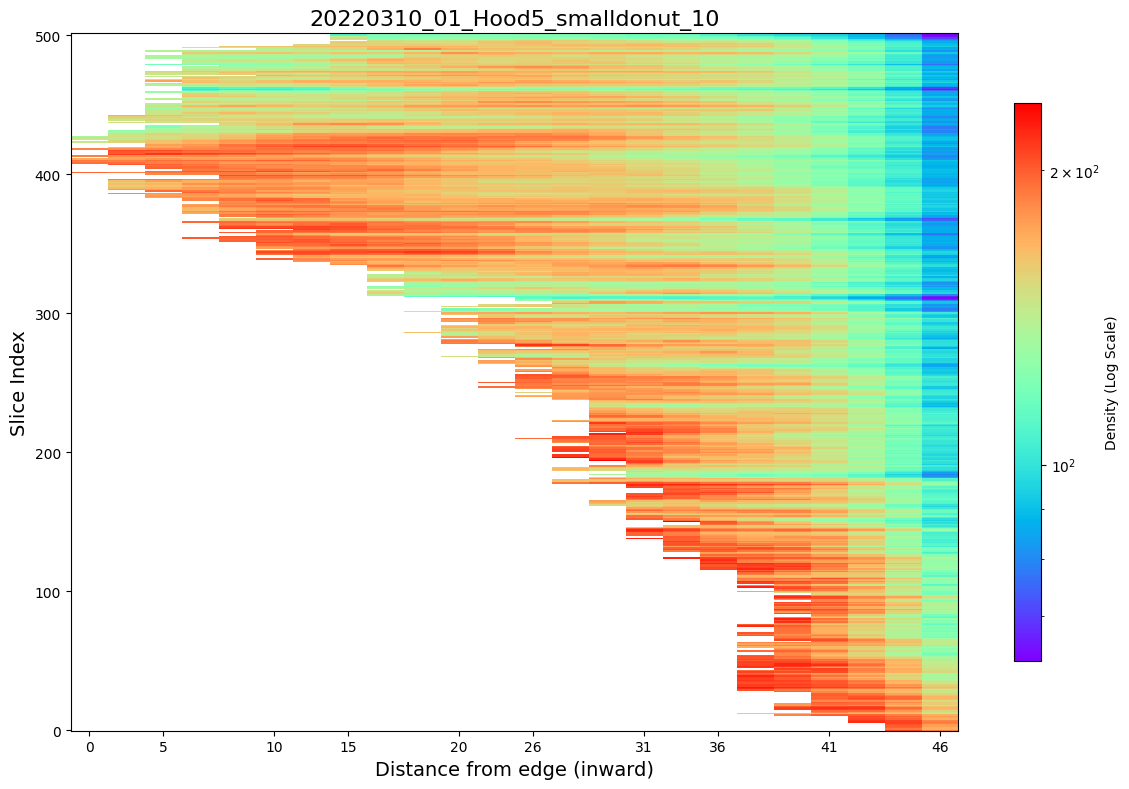

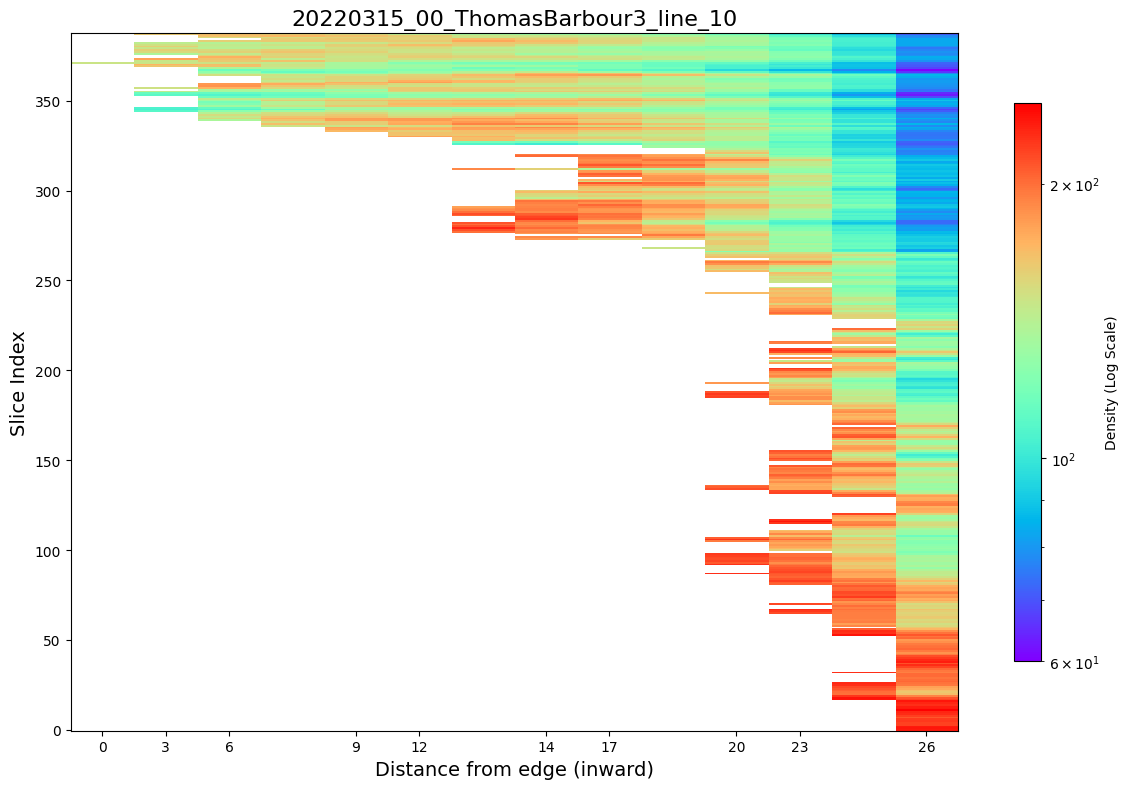

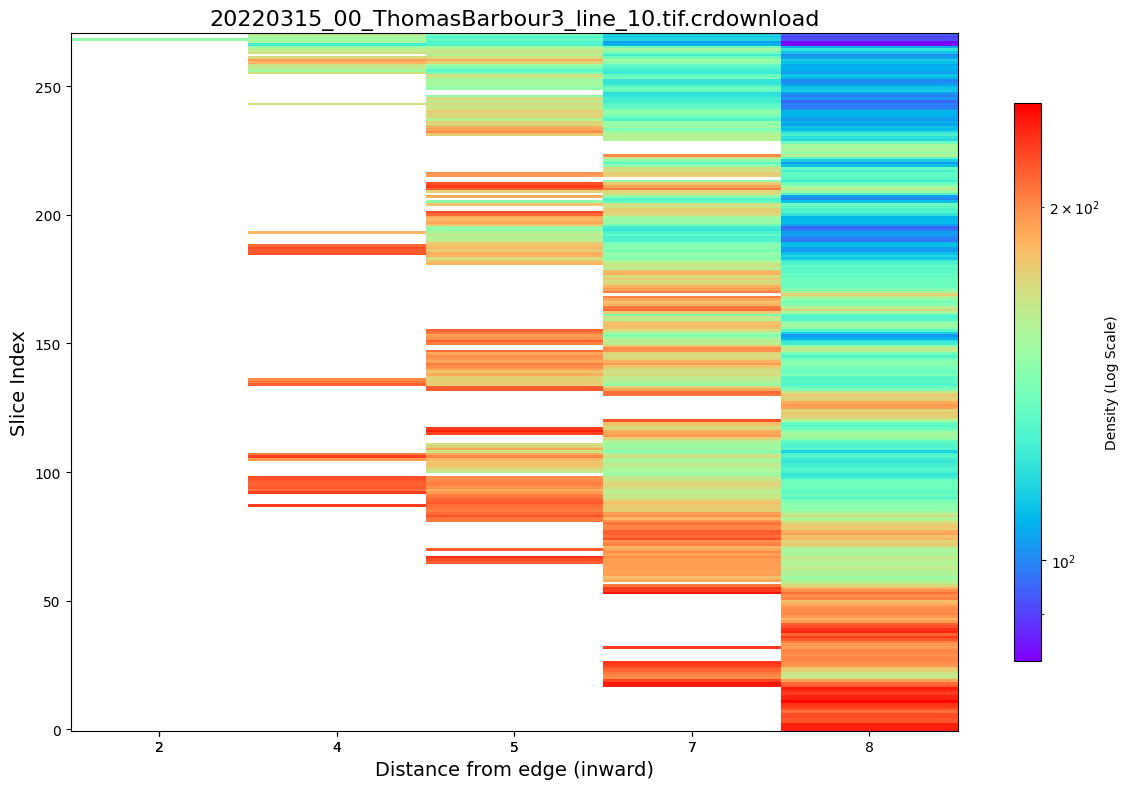

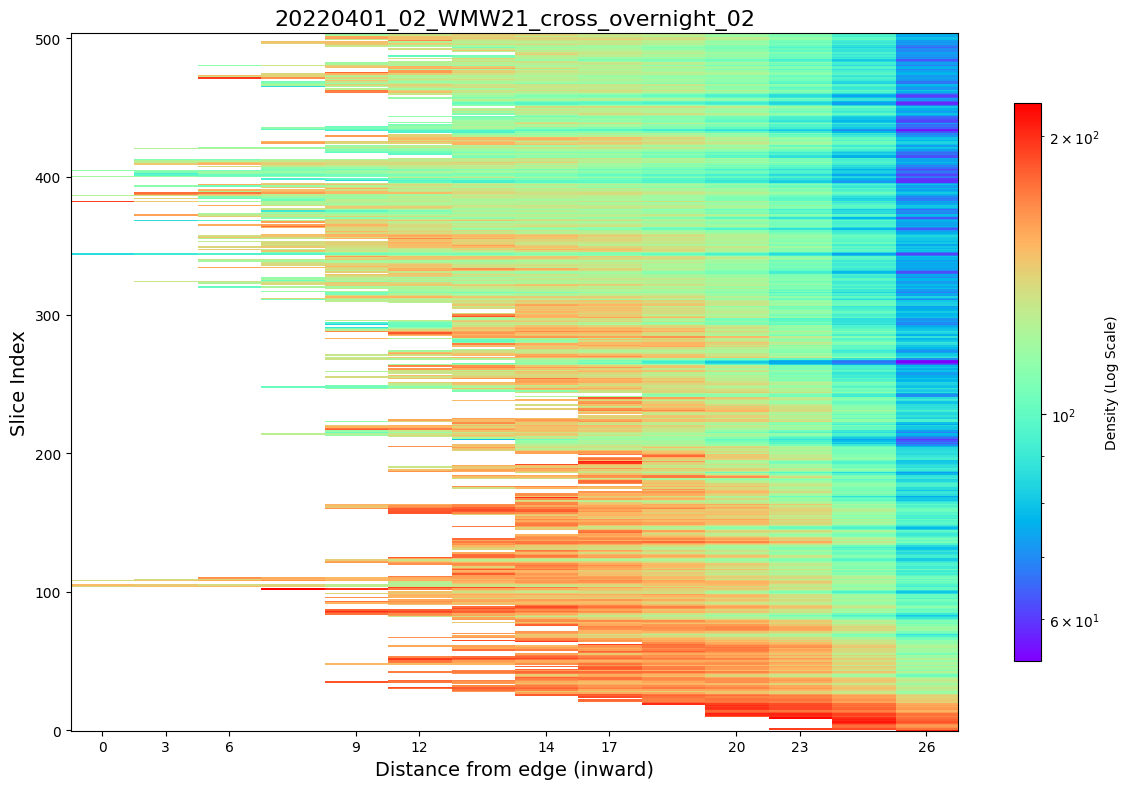

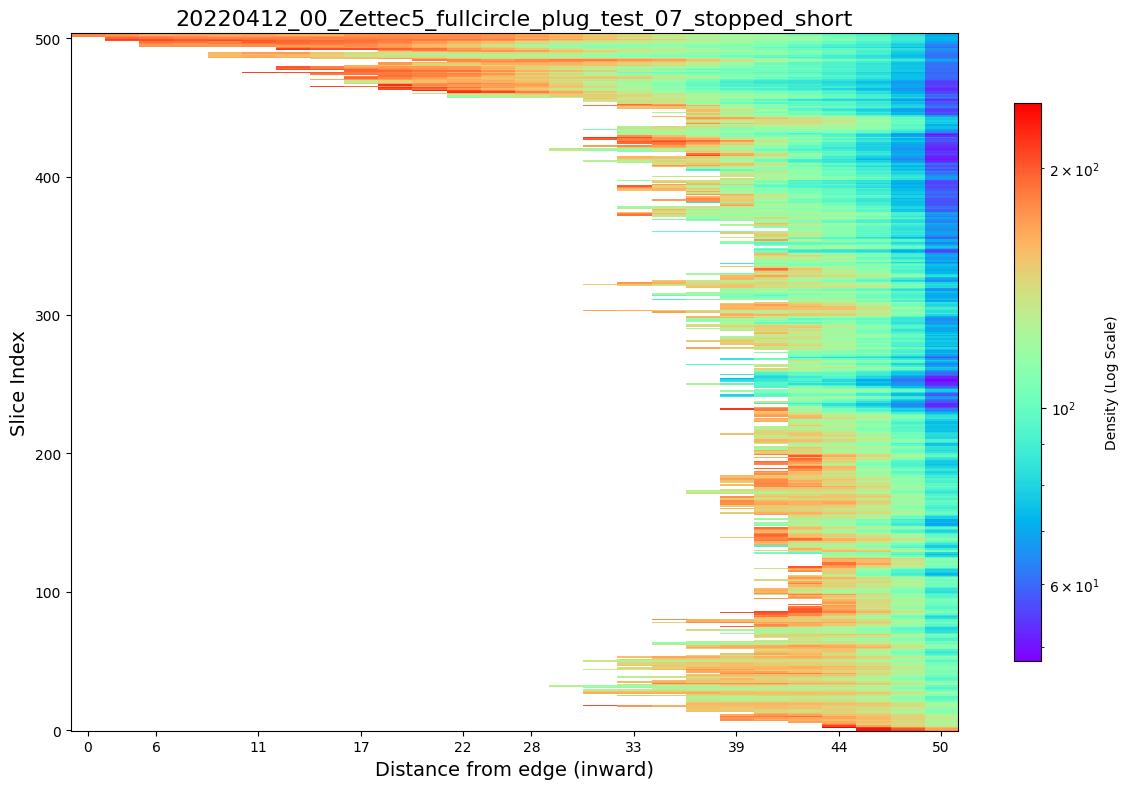

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import os

# Add the list of CSV file paths
csv_paths = [
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220310_01_Hood5_smalldonut_10.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220315_00_ThomasBarbour3_line_10.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220315_00_ThomasBarbour3_line_10.tif.crdownload.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220401_02_WMW21_cross_overnight_02.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.csv"
]

for path in csv_paths:

    results_df = pd.read_csv(path)


    max_distance = results_df["Distance"].max()
    results_df["DistanceFromCenter"] = max_distance - results_df["Distance"]


    pivot_table = results_df.pivot(index="Slice", columns="DistanceFromCenter", values="BandMedian")
    pivot_table = pivot_table.sort_index(axis=0)
    pivot_table = pivot_table.sort_index(axis=1)

    pivot_array = pivot_table.to_numpy()
    pivot_array[pivot_array == 0] = 1e-2

    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(
        pivot_array,
        aspect='auto',
        cmap='rainbow',
        origin='lower',
        interpolation='nearest',
        norm=LogNorm(vmin=np.nanmin(pivot_array), vmax=np.nanmax(pivot_array))
    )

    plt.colorbar(label='Density (Log Scale)', shrink=0.8)
    plt.xlabel("Distance from edge (inward)", fontsize=14)
    plt.ylabel("Slice Index", fontsize=14)


    title = os.path.splitext(os.path.basename(path))[0]
    plt.title(title, fontsize=16)


    num_ticks = 10
    tick_positions = np.linspace(0, pivot_array.shape[1] - 1, num_ticks, dtype=int)
    tick_labels = np.round(np.linspace(pivot_table.columns.min(), pivot_table.columns.max(), num_ticks)).astype(int)
    plt.xticks(ticks=tick_positions, labels=tick_labels)

    plt.tight_layout()
    plt.show()


#Run this to download the figures.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import os
from google.colab import files

# List of CSV file paths
csv_paths = [
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220310_01_Hood5_smalldonut_10.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220315_00_ThomasBarbour3_line_10.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220315_00_ThomasBarbour3_line_10.tif.crdownload.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220401_02_WMW21_cross_overnight_02.csv",
    "/content/drive/MyDrive/ants/ant_csv_median_results/20220412_00_Zettec5_fullcircle_plug_test_07_stopped_short.csv"
]

output_dir = "/content/heatmaps"
os.makedirs(output_dir, exist_ok=True)

for path in csv_paths:
    # Read the CSV
    results_df = pd.read_csv(path)

    # Compute inward distance
    max_distance = results_df["Distance"].max()
    results_df["DistanceFromCenter"] = max_distance - results_df["Distance"]

    # Pivot into matrix
    pivot_table = results_df.pivot(index="Slice", columns="DistanceFromCenter", values="BandMedian")
    pivot_table = pivot_table.sort_index(axis=0)
    pivot_table = pivot_table.sort_index(axis=1)

    pivot_array = pivot_table.to_numpy()
    pivot_array[pivot_array == 0] = 1e-2  # avoid log(0)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(
        pivot_array,
        aspect='auto',
        cmap='rainbow',
        origin='lower',
        interpolation='nearest',
        norm=LogNorm(vmin=np.nanmin(pivot_array), vmax=np.nanmax(pivot_array))
    )

    plt.colorbar(label='Density (Log Scale)', shrink=0.8)
    plt.xlabel("Distance from edge (inward)", fontsize=14)
    plt.ylabel("Slice Index", fontsize=14)

    # Use filename (without extension) as title
    title = os.path.splitext(os.path.basename(path))[0]
    plt.title(title, fontsize=16)

    # Nice x-ticks
    num_ticks = 10
    tick_positions = np.linspace(0, pivot_array.shape[1] - 1, num_ticks, dtype=int)
    tick_labels = np.round(np.linspace(pivot_table.columns.min(), pivot_table.columns.max(), num_ticks)).astype(int)
    plt.xticks(ticks=tick_positions, labels=tick_labels)

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(output_dir, f"{title}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # Download the file immediately
    files.download(save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>